# Credit Card Customer Segmentation
In this project, we play the role of a data scientist. The project contains information about a company's clients. We are tasked with segmenting them into different groups in order to apply different business strategies for each customer type.

## The Dataset
The dataset arrives to us cleaned, so we can focus on building the best model right away. The model determined to be used to segment the data is the K-means algorithm. We are not allowed to build a different model.

The company wants to see an explanation of the characteristics of each group of customers and the main points that make them different.

The steps we will follow in order to achieve the goals the company has set for us are as follows:
1. Analyze the dataset
2. Prepare the data for modeling
3. Determine the optimal number of clusters for segmenting the data
4. Segment the data
5. Interpret and explain the results

The dataset consists of the following columns:
- customer_id: unique customer identifier
- age: age of customer in years
- gender: gender of customer (M or F)
- dependent_count: number of dependents the customer has
- education_level: customer's level of education ('High School', 'Graduate', etc.)
- marital_status: marital status ('Single', 'Married', etc.)
- estimated_income: estimated customer income projected by the data science team
- months_on_book: time as a customer in months
- total_relationship_count: number of times the customer has contacted the company
- months_inactive_12_mon: number of months customer did not use the credit card in the last 12 months
- credit_limit: customer's credit limit
- total_trans_amount: Total spent on the credit card by the customer
- total_trans_count: Total number of transactions on the credit card by the customer
- avg_utilization_ratio: daily average utilization ratio

In [72]:
# Library Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

%matplotlib inline

In [73]:
# Helper Functions
# def distribution_plots(df):
#     for col in df.columns:
#         plt.hist(df[col])
#         plt.title('{}'.format(col))
#         plt.show()
#         print('\n')

def distribution_plots(df):
    fig = plt.figure(figsize=(12, 20))
    for i, col in enumerate(df.columns):
        ax = fig.add_subplot(7, 2, i+1)
        ax.hist(df[col])
        ax.set_title('{}'.format(col))
        ax.xaxis.grid(False)
    plt.tight_layout()
    plt.show()

In [74]:
# Read the dataset in
customers = pd.read_csv('customer_segmentation.csv')

# Explore the dataset
print('Size of dataset:', customers.shape)
print('\n')

print('Number of Missing Values')
print(customers.isnull().sum())
print('\n')

print('Data types and information of the dataset')
print(customers.info())

Size of dataset: (10127, 14)


Number of Missing Values
customer_id                 0
age                         0
gender                      0
dependent_count             0
education_level             0
marital_status              0
estimated_income            0
months_on_book              0
total_relationship_count    0
months_inactive_12_mon      0
credit_limit                0
total_trans_amount          0
total_trans_count           0
avg_utilization_ratio       0
dtype: int64


Data types and information of the dataset
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_id               10127 non-null  int64  
 1   age                       10127 non-null  int64  
 2   gender                    10127 non-null  object 
 3   dependent_count           10127 non-null  int64  
 4   education_level        

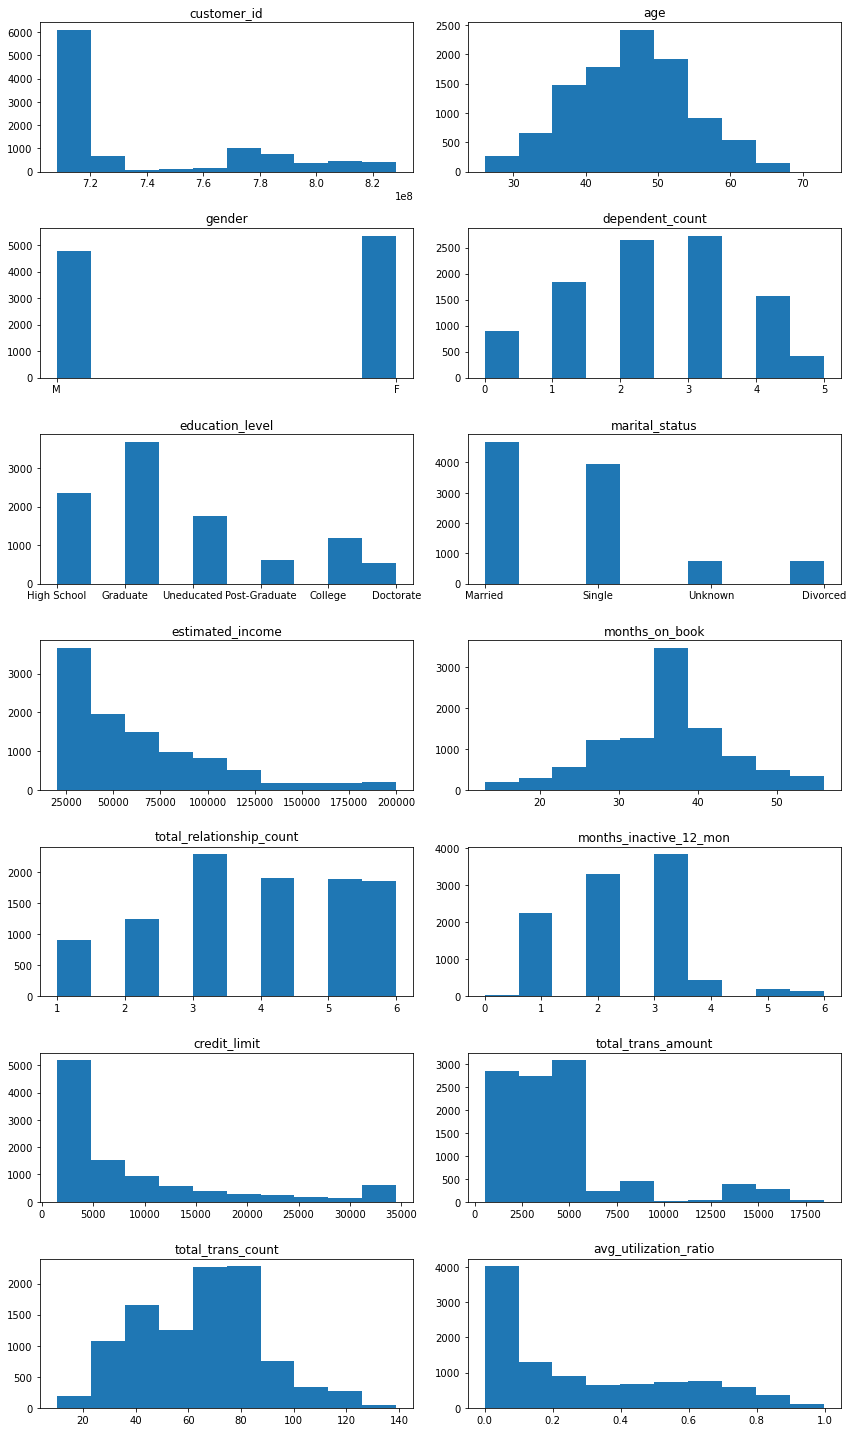

In [75]:
# Plotting distribution of Columns to further explore outliers and incorrect values
distribution_plots(customers)

By examining the histograms of the features, we can better understand their distributions and whether or not the outliers were sufficently cleaned from the data. These distributions appear to have been cleaned of outliers, and show characteristics of either a normal distribution or right skewed distribution. Right skewed distributions often appear in financial datasets such as these, as income is often heavily skewed right.

Text(0.5, 1.0, 'Examining Potential Correlations Between Features')

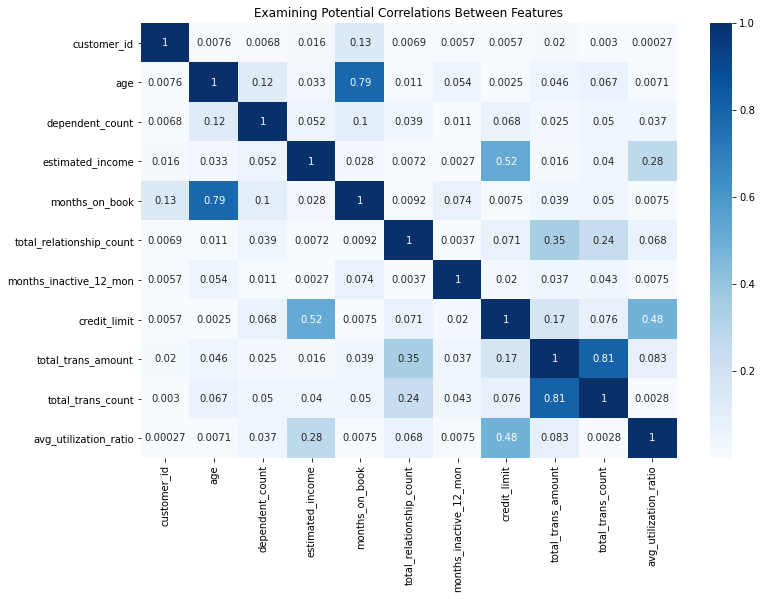

In [76]:
# Plotting heatmap of correlations

correlations = abs(customers.corr())
plt.figure(figsize=(12,8))
sns.heatmap(correlations, annot=True, cmap='Blues')
plt.title('Examining Potential Correlations Between Features')

We can see some useful correlations in the dataset, some of which seem obvious/make sense. Such as total_trans_amount and total_trans_count being highly correlated. Often times, people with a credit card tend to use it frequently, as there are often times reward points and bonuses involved from the company to keep the customer active and loyal with their card.

## Feature Engineering

In order to use all features available to us, we must deal with the categorical columns. These columns are 'gender', 'education_level', 'marital_status'.

The gender column can easily be converted to a binary column, 1 for M and 0 for F. The education_level column contains 6 values, which can be ranked from highest to lowest on a numerical scale.

The marital_status column as 4 unique values which cannot be ranked in any appropriate way. Therefore, the best solution is to use one-hot-encoding to create dummy variables from this column.

In [78]:
# Create a copy of the dataset so we do not overwrite the original
customers_modif = customers.copy()

# Modifying the gender column
customers_modif['gender'] = customers_modif['gender'].apply(lambda x: 1 if x == 'M' else 0)

# Modifying the education_level column
customers_modif.replace(to_replace={'Uneducated': 0, 'High School': 1, 'College':2,
                                    'Graduate': 3, 'Post-Graduate': 4, 'Doctorate':5}, inplace=True)

# Modifying the marital_status column
#dummies = pd.get_dummies(customers_modif[['marital_status']], drop_first=True)
#customers_modif = pd.concat([customers_modif, dummies], axis=1)
#customers_modif.drop(['marital_status'], axis=1, inplace=True)
customers_modif = pd.get_dummies(data=customers_modif, columns=['marital_status'], drop_first=True)

# Examing the changes
print(customers_modif.head())

   customer_id  age  gender  dependent_count  education_level  \
0    768805383   45       1                3                1   
1    818770008   49       0                5                3   
2    713982108   51       1                3                3   
3    769911858   40       0                4                1   
4    709106358   40       1                3                0   

   estimated_income  months_on_book  total_relationship_count  \
0             69000              39                         5   
1             24000              44                         6   
2             93000              36                         4   
3             37000              34                         3   
4             65000              21                         5   

   months_inactive_12_mon  credit_limit  total_trans_amount  \
0                       1       12691.0                1144   
1                       1        8256.0                1291   
2                       1    

## Scaling the Data
Scaling the data before training the model is extremely important, especially when dealing with algorithms that are trying to make decisions based on distance calculates. Large values can affect the performance of the model when compared to small values, so scaling the data to be in a consistent range will greatly improve performance.

In [79]:
# Dropping customer_id column in order to scale features appropriately
X = customers_modif.drop('customer_id', axis=1)

# Scaling Data
ss = StandardScaler()
ss.fit(X)
X_scaled = ss.transform(X)

# Converting the scaled dataset back to a pd dataframe
X = pd.DataFrame(X_scaled)
print(X.head())

         0         1         2         3         4         5         6   \
0 -0.165406  1.059956  0.503368 -0.752211  0.175810  0.384621  0.763943   
1  0.333570 -0.943436  2.043199  0.662787 -0.967166  1.010715  1.407306   
2  0.583058  1.059956  0.503368  0.662787  0.785397  0.008965  0.120579   
3 -0.789126 -0.943436  1.273283 -0.752211 -0.636973 -0.241473 -0.522785   
4 -0.789126  1.059956  0.503368 -1.459710  0.074212 -1.869317  0.763943   

         7         8         9         10        11        12        13  \
0 -1.327136  0.446622 -0.959707 -0.973895 -0.775882  1.077338 -0.798507   
1 -1.327136 -0.041367 -0.916433 -1.357340 -0.616276 -0.928214  1.252337   
2 -1.327136 -0.573698 -0.740982 -1.911206 -0.997155  1.077338 -0.798507   
3  1.641478 -0.585251 -0.951758 -1.911206  1.759686 -0.928214 -0.798507   
4 -1.327136 -0.430877 -1.056263 -1.570365 -0.997155  1.077338 -0.798507   

         14  
0 -0.282609  
1 -0.282609  
2 -0.282609  
3  3.538459  
4 -0.282609  


## Choosing K
The dataset is now ready for machine learning. The next step is to decide a value for K, the number of clusters. To do this, several models will be created and the inertia from each will be plotted. We can then use the elbow rule to determine our optimal value for K.

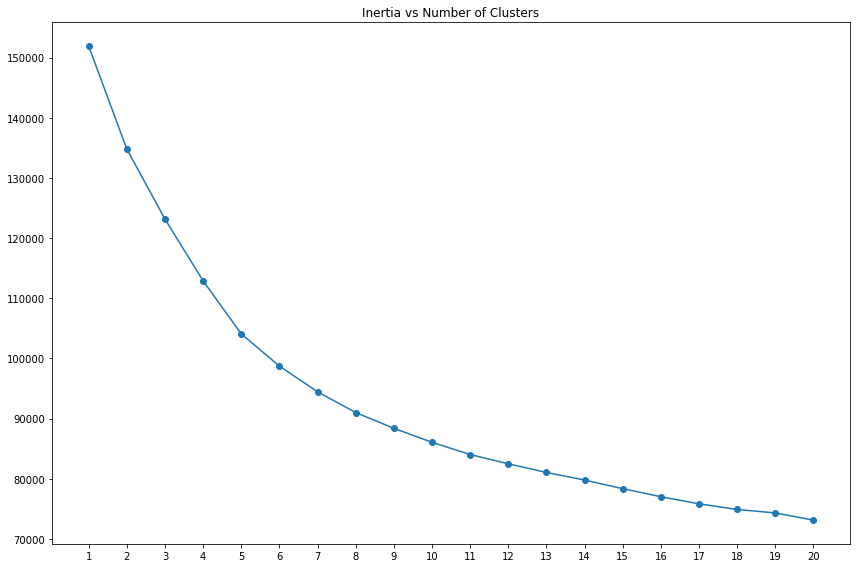

In [80]:
# Empty list to gather inertias
inertias = []

# Creating various models using different values for K
for k in range(1, 21):
    model = KMeans(n_clusters=k)
    y = model.fit_predict(X)
    inertias.append(model.inertia_)
    
# Plotting the inertias
plt.figure(figsize=(12, 8))
plt.plot(range(1, 21), inertias, marker='o')
plt.xticks(ticks=range(1, 21), labels=range(1, 21))
plt.title('Inertia vs Number of Clusters')

plt.tight_layout()
plt.show()

The plot above shows a decreasing rate of inertia between 5 and 7 clusters. We will use 6 clusters as a good starting point.

In [99]:
# Creating model with K=6
model = KMeans(n_clusters=6)
y = model.fit_predict(X_scaled)
print(y)

[2 3 2 ... 1 0 1]


## Analyzing the Results
We now must analyze and present the results in a way that fits with the goals of the project given to us by the company. This will involve noting the most important characteristics of each cluster and how they can impact the business.

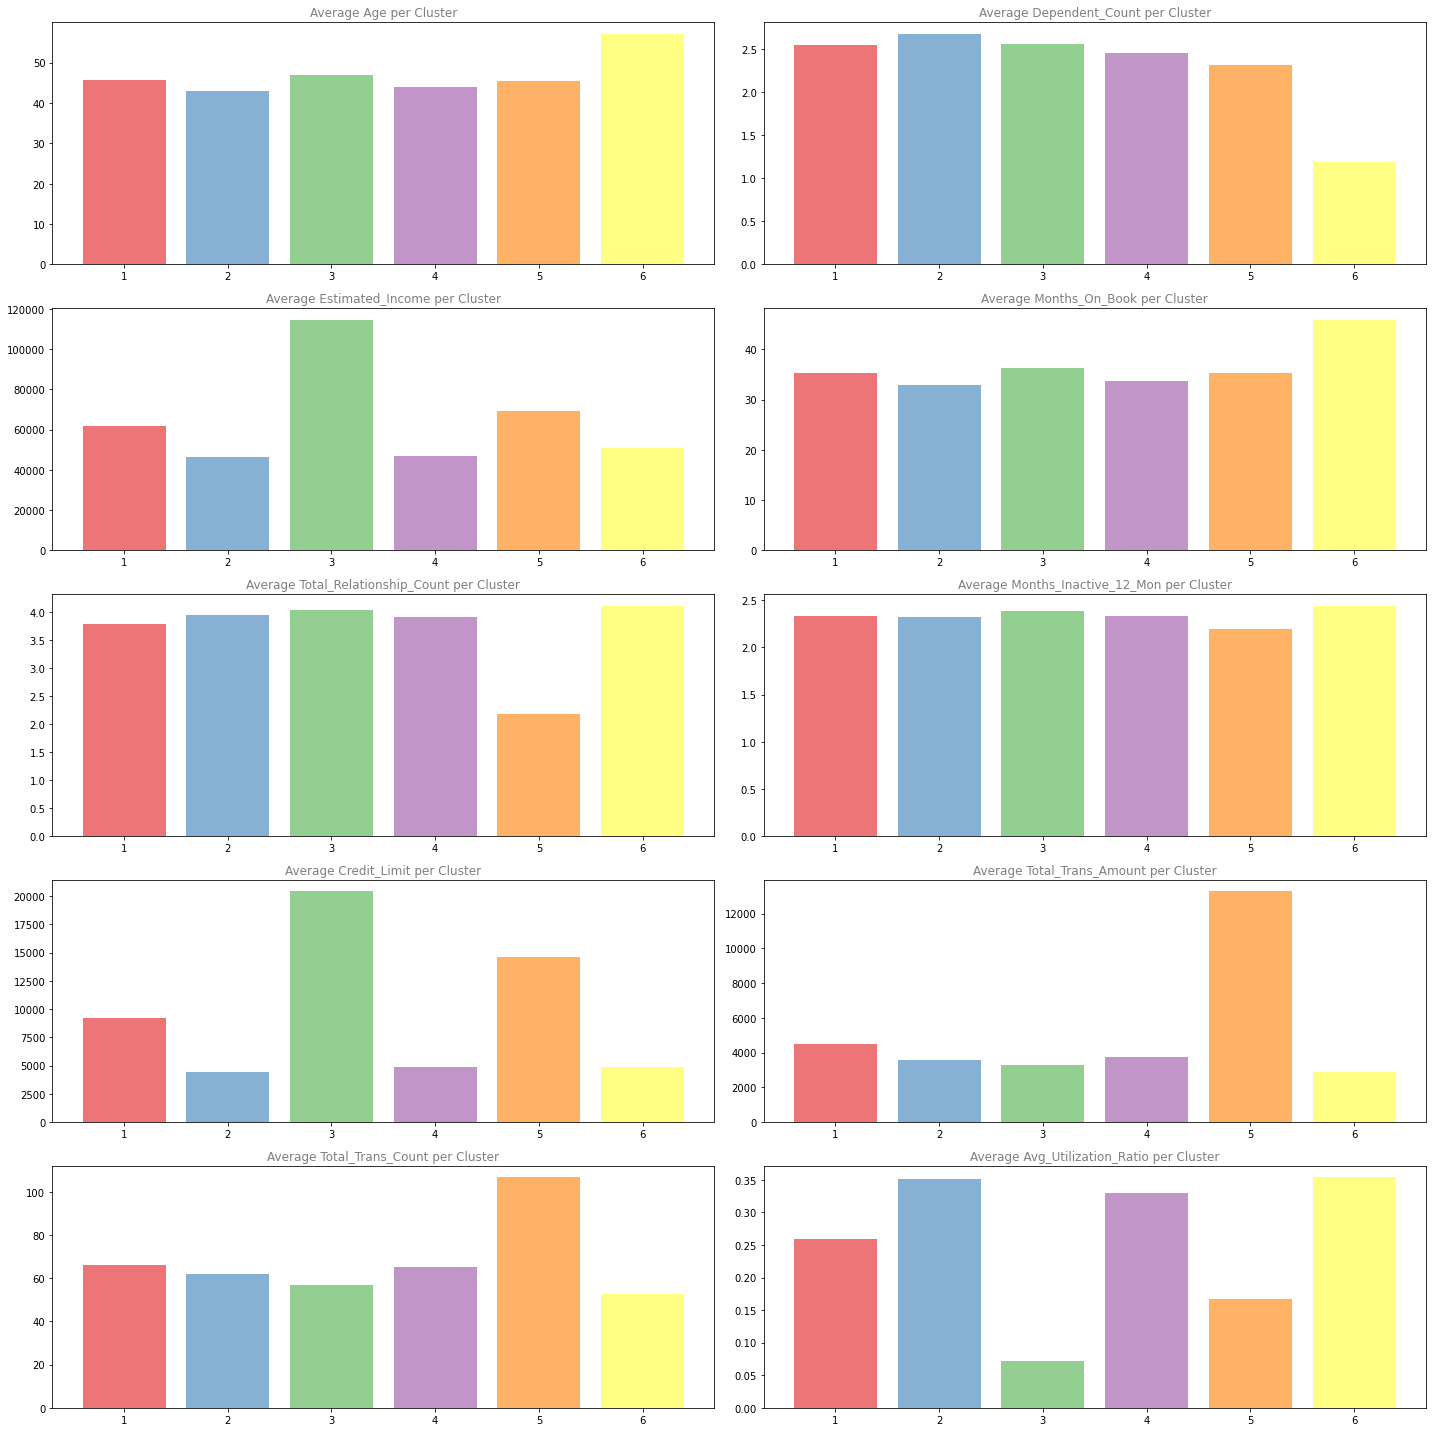

In [100]:
# Creating CLUSTER column in original dataset to assign clusters (y+1 due to numbering scheme of python)
customers['CLUSTER'] = y + 1

# Grouping numeric variables by CLUSTER and plotting to analyze
numeric_columns = customers.select_dtypes(include=np.number).drop(['customer_id', 'CLUSTER'], axis=1).columns

fig = plt.figure(figsize=(20, 20))
for i, column in enumerate(numeric_columns):
    df_plot = customers.groupby('CLUSTER')[column].mean()
    ax = fig.add_subplot(5, 2, i+1)
    ax.bar(df_plot.index, df_plot, color=sns.color_palette('Set1'), alpha=0.6)
    ax.set_title(f'Average {column.title()} per Cluster', alpha=0.5)
    ax.xaxis.grid(False)
    
plt.tight_layout()
plt.show()

For the variables that have high correlations, we can use a scatter plot to visualize the correlation by cluster

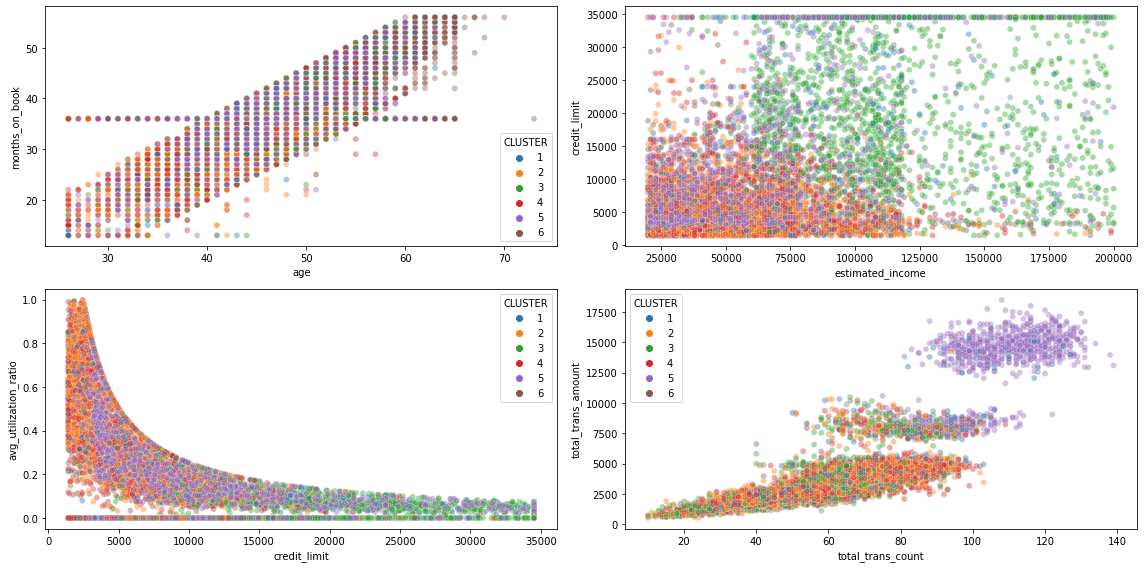

In [102]:
# Visualizing high correlation variables with scatter plot
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 8))
sns.scatterplot(x='age', y='months_on_book', hue='CLUSTER', data=customers, palette='tab10', alpha=0.4, ax=ax1)
sns.scatterplot(x='estimated_income', y='credit_limit', hue='CLUSTER', data=customers, palette='tab10', alpha=0.4, ax=ax2, legend=False)
sns.scatterplot(x='credit_limit', y='avg_utilization_ratio', hue='CLUSTER', data=customers, palette='tab10', alpha=0.4, ax=ax3)
sns.scatterplot(x='total_trans_count', y='total_trans_amount', hue='CLUSTER', data=customers, palette='tab10', alpha=0.4, ax=ax4)

plt.tight_layout()
plt.show()


For the categorical columns we will plot the percentual distribution of each variable per cluster. This will give us insight into what groups of people make up each cluster (from a categorical point of view).

## Jupyter Notebook broke the next segment of code, still working on the debug...